# Vision Transformer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.nn.modules.linear import Linear
import torch.nn as nn
from torchsummary import summary
import math

## SelfAttention

In [2]:
def masked_attention(query, key, value, mask=None):
    """
    Inputs:
        query: torch.Tensor, (N, d_k)
        key: torch.Tensor, (M, d_k)
        value: torch.Tensor, (M, d_v)
        (optional) mask: torch.Tensor, (N, M) (query, key) = 1 or 0
    Output: torch.Tensor, (N, d_v)
    
    Hint) use torch.Tensor.masked_fill
    """
    d_k = key.shape[1]
    
    # (step 1) smilarity between query and key
    sim = torch.mm(query, key.transpose(-2, -1)) # (N, M) torch.matmul
    # (step 2) scaling
    sim = sim / math.sqrt(d_k) # (N, M)
    # (masking)
    if mask is not None:
        sim = sim.masked_fill(mask=~mask, value=-np.inf)
    # (step 3) softmax
    attn = torch.softmax(sim, dim=1) # torch.sum(attn, dim=1) = [1, 1, 1, ...] (N, M)
    # (step 4) weighted aggregation!
    out = torch.mm(attn, value) # (N, M) * (M, D) = (N, D)
    return out

In [3]:
N, M, d_k, d_v = 3, 4, 5, 6

query = torch.randn(N, d_k)
key = torch.randn(M, d_k)
value = torch.randn(M, d_v)

out = masked_attention(query, key, value)
print(out.shape)

torch.Size([3, 6])


In [4]:
def batch_masked_multi_head_attention(query, key, value, mask=None):
    """
    Inputs:
        query: torch.Tensor, (B, H, N, D)
        key: torch.Tensor, (B, H, M, D)
        value: torch.Tensor, (B, H, M, D)
        (optional) mask: torch.Tensor, (B, N, M)
    Output: torch.Tensor, (B, H, N, D)
    
    Hint) use torch.Tensor.masked_fill
    """
    d_k = key.shape[-1]
    
    # (step 1) smilarity between query and key
    key = key.transpose(2, 3) # (B, H, D, M)
    sim = torch.mm(query, key) # (B, H, N, D) * (B, H, D, M) = (B, H, N, M)
    # (step 2) scaling
    sim = sim / math.sqrt(d_k) # (B, H, N, M)
    # (masking)
    if mask is not None:
        sim = sim.masked_fill(mask=~mask.unsqueeze(1), value=-np.inf) # (B, 1, N, M)
    # (step 3) softmax
    attn = torch.softmax(sim, dim=-1) # torch.sum(attn, dim=-1) = [1, 1, 1, ...] (B, H, N)
    # (step 4) weighted aggregation!
    out = torch.mm(attn, value) # (B, H, N, M) * (B, H, M, D) = (B, H, N, D)
    return out

### MultiHeadAttention

In [5]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, h):
        super(MultiHeadAttentionLayer, self).__init__()
        
        self.d_model = d_model
        self.h = h
        self.query_fc_layer = nn.Linear(d_model, d_model)
        self.key_fc_layer = nn.Linear(d_model, d_model)
        self.value_fc_layer = nn.Linear(d_model, d_model)
        self.fc_layer = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        # query, key, value's shape: [Batch, seq_len, d_model] [Batch, 197, 768]
        # mask's shape: [Batch, seq_len, seq_len]
        n_batch = query.shape[0] 

        def transform(x, fc_layer): # reshape (Batch, seq_len, d_model) to (n_batch, h, seq_len, d_k)
            out = fc_layer(x) # out's shape: (Batch, seq_len, d_model)
            out = out.view(n_batch, -1, self.h, self.d_model//self.h) # out's shape: (Batch, seq_len, h, d_k) [Batch, 197, 12, 64]
            out = out.transpose(1, 2) # out's shape: (Batch, h, seq_len, d_k) [Batch, 12, 197, 64]
            return out

        query = transform(query, self.query_fc_layer) # query, key, value's shape: (Batch, h, seq_len ,d_k) #[Batch, 12, 197, 64]
        key = transform(key, self.key_fc_layer) #[Batch, 12, 197, 64]
        value = transform(value, self.value_fc_layer) #[Batch, 12, 197, 64]

        if mask is not None:
            mask = mask.unsqueeze(1) # mask's shape: (Batch, 1, seq_len, seq_len)

        out = self.calculate_attention(query, key, value, mask) # out's shape: (Batch, h, seq_len, d_k)
        out = out.transpose(1, 2) # out's shape: (Batch, seq_len, h, d_k)
        out = out.reshape(n_batch, -1, self.d_model) # out's shape: (Batch, seq_len, d_model)
        out = self.fc_layer(out) # out's shape: (Batch, seq_len, d_embed)
        return out
    
    def calculate_attention(self,query, key, value, mask = None):
        # query, key, value's shape: (Batch, h, seq_len ,d_k)
        d_k = key.size(-1) # get d_k
        attention_score = torch.matmul(query, key.transpose(-2, -1)) # Q x K^T, attention_score's shape: (n_batch, h, seq_len, seq_len)
        attention_score = attention_score / math.sqrt(d_k) # scaling
        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0, -1e9) # masking
        attention_prob = F.softmax(attention_score, dim=-1) # softmax, attention_prob's shape: (n_batch, h, seq_len, seq_len)
        out = torch.matmul(attention_prob, value) # Attention_Prob x V, out's shape: (n_batch, h, seq_len, d_k)
        return out

### Transformer Encoder

In [11]:
# Now create the Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model =768, num_heads = 12):
        super(TransformerEncoderBlock, self).__init__()
        
        self.layernorm = nn.LayerNorm(d_model)
        self.mh_attn = MultiHeadAttentionLayer(d_model = d_model, h = num_heads)
               
        self.second = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, d_model * 4), ##mlp hidden dim 4배 키운다음에 다시 줄여줌
                nn.GELU(),
                nn.Linear(d_model * 4, d_model)
            )
    
    def forward(self, x):
        ##input has shape: [Batch, 197, 768]
        #first
        res = x
        x = self.layernorm(x)
        x = self.mh_attn(x, x, x)
        x = x + res
        
        #second
        res = x
        x = self.second(x)
        x = x + res
        
        return x
    
    
# TransformerEncoder consists of L blocks of TransformerBlock
class TransformerEncoder(nn.Module):
    def __init__(self, depth=12, d_model = 768, num_heads = 12):
        super(TransformerEncoder, self).__init__()
        
        blocks = []
        for i in range(depth):
            blocks.append(TransformerEncoderBlock(d_model = d_model, num_heads = num_heads))
        
        self.transformer_encoder = nn.Sequential(*blocks)
        
    def forward(self, x):
        return self.transformer_encoder(x)

### ViT Class

In [12]:
class ViT(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, 
                num_class = 10, d_model = 768, n_head = 12, 
                n_layers = 12, channels = 3):
        super(ViT, self).__init__()

        img_h, img_w = img_size, img_size ##224, 224
        patch_h, patch_w = patch_size, patch_size  ## 16, 16

        assert img_h % patch_h == 0, 'image dimension must be divisible by patch dimension'

        num_patches = (img_h // patch_h) * (img_w // patch_w) ## 14 * 14
        patch_dim = channels * patch_h * patch_w  # c*p*p ## 3 * 16 * 16

        self.patches_embed = nn.Sequential(
            #[Batch, channel, img_h, img_w] = [Batch, channel, h * patch_h, w * patch_w]
            # [Batch, h * w, patch_h * patch_w * c]
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_h, p2 = patch_w), 
            nn.Linear(patch_dim, d_model)
        ) #[Batch, h * w, d_model]
        
        
#         input = x
#         x = x.view(x.shape[0], c, patch_h, patch_size, patch_w, patch_size)
#         x = x.permute(0, 2, 4, 3, 5, 2) # [batch, patch_h, patch_w, patch_size, patch_size, c]
#         x = x.view(x.shape[0], -1, patch_size * patch_size * 3)
        
        ##define class token
        ## [1, 1, d_model]
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model)) ##class token을 붙이면 총 n+1 token
        
        ##learnable positional embedding
        ## [1, num_patches + 1, d_model]
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, d_model)) ##learnable positional embedding
        
        
        ## define transformer
        self.transformer = TransformerEncoder(depth = n_layers) ##저희가 구현한 transformerEncoder 모듈입니다. 
        
#         encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead = n_head)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers = n_layers) ### 이와 같이 torch.nn에 정의되어있는 TransformerEncoder를 사용할 수 있습니다. 
        
        ###  mlp head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_class)
        )
    
    def forward(self, img):
        #[Batch, 3, 224, 224]
        ##input image shape [B, 3, img_h, img_w] or [B, 3, h * patch_size, w * patch_size]
        ##after rearrage [B, h * w, patch_size * patch_size * c]
        ### 각 patch의 embedding을 만들어줌
        x = self.patches_embed(img) ## after linear [B, h * w, d_model] [Batch, 196, 768]
        
        b, n, _ = x.shape
        ###Class token을 만들어줌 #[1, 1, 768]  -> [B, 1, 768]
        class_token = repeat(self.class_token, '() n d -> b n d', b = b) # [1, 1, d_model] 사이즈인 class 토큰을 배치 개수만큼 늘려줌. [B, 1, d_model]
        
        #Concat Class Token with image patches
        x = torch.cat((class_token,x), dim=1) ## cls token과 image patches를 concat. [B, h * w + 1, d_model] [B, ]
        ## [Batch, 197, 768]
        
        ## positional encoding을 더해줌.
        x = x + self.pos_embed[:, :(n+1)] ## [B, h * w + 1, d_model]
        ## [Batch, 197, 768]
        
        ## transformer에 인풋으로 넣어준다.
        x = self.transformer(x) ##[B, h * w + 1, d_model]
        ## [Batch, 197, 768 ]
        
        
        ## cls token 가져옴
        x = x[:, 0] ##prediction을 위한 cls token ## [B, d_model]
        #[Batch, 768]
        
        #MLP Head
        x = self.mlp_head(x)
        #[Batch, 10]
        return x



### Load Train, Test Dataset and Define Train, Test Loader

In [13]:
# Loading and normalizing CIFAR-10
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)
print(len(trainset))
print(len(testset))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
50000
10000


### For Visualization

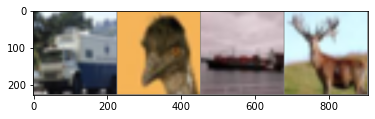

truck  bird  ship  deer


In [14]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define model

In [15]:
device = "cuda:0"
x = torch.randn(16,3,224,224).to(device)
model = ViT(n_head = 6).to(device)
output = model(x)
print(output.shape)

torch.Size([16, 10])


### Define Loss and optimizer

In [16]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training

In [17]:
### Train the network
print('Start Training ')
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # Fill this loop
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # print statistics
        if i % 50 == 0:
            print('[%d, %5d] loss: %.6f' %
                 (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

Start Training 
[1,     1] loss: 0.004154
[1,    51] loss: 0.301965
[1,   101] loss: 0.234038
[1,   151] loss: 0.234874
[1,   201] loss: 0.237495
[1,   251] loss: 0.226717
[1,   301] loss: 0.231063
[1,   351] loss: 0.220311
[1,   401] loss: 0.213876
[1,   451] loss: 0.205944
[1,   501] loss: 0.209500
[1,   551] loss: 0.208427
[1,   601] loss: 0.213725
[1,   651] loss: 0.215761
[1,   701] loss: 0.195238
[1,   751] loss: 0.208445
[1,   801] loss: 0.203962
[1,   851] loss: 0.217705
[1,   901] loss: 0.200498
[1,   951] loss: 0.196163
[1,  1001] loss: 0.207225
[1,  1051] loss: 0.202954
[1,  1101] loss: 0.190841
[1,  1151] loss: 0.210985
[1,  1201] loss: 0.202158
[1,  1251] loss: 0.199322
[1,  1301] loss: 0.201088
[1,  1351] loss: 0.189266
[1,  1401] loss: 0.205669
[1,  1451] loss: 0.196401
[1,  1501] loss: 0.197915
[1,  1551] loss: 0.198066
[1,  1601] loss: 0.193360
[1,  1651] loss: 0.192805
[1,  1701] loss: 0.187569
[1,  1751] loss: 0.188970
[1,  1801] loss: 0.196853
[1,  1851] loss: 0.194

KeyboardInterrupt: 

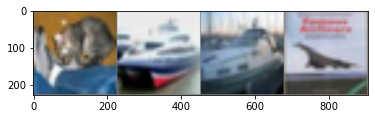

GrondTruth:    cat  ship  ship plane


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
images = images.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4))) 

Predicted:    car   car  ship  ship
